# Project 5: Infinite Impulse Response Filter Design
There are four classical IIR filters: (1) Butterworth (2) Chebyshev I (3) Chebyshev II (4) Elliptic. They represent four different combinations of two error approximation measures. The first measure uses the Taylor series while the other minimizes the difference between the desired and actual response over a band of frequencies. 

We will explore and compare various methods for designing IIR filters in this Project

## Objective

1. Design a 6<sup>th</sup>-order low-pass Butterworth filter.
    1. Plot the magnitude and phase responses.
    2. Plot the significant part of the impulse response to give around 30 output values.

2. Repeat #1 for a Chebyshev I filter with a passband ripple of $1~\text{dB}$ and plot the magnitude, phase, and frequency response.

3. Repeat #1 for a Chebyshev II filter with a stopband cutoff of $0.3\pi$ and maximum stopband ripple of $30~\text{dB}$ 

4. Repeat #1 for a Ellipse filter with a passband cutoff of $0.3\pi$ and passband ripple of $1~\text{dB}$ and maximum stopband ripple of $30~\text{dB}$.

5. Read the audio file into the notebook <code>doorbell.wav</code>.
    1. Determine the upper and lower frequencies of the doorbell.
    2. Design a filter such that the lower tone is attenuated no more than $3~\text{dB}$ while the upper tone is attenuated $15~\text{dB}$.
    3. Design all four types of filter and plot the frequency response and resulting spectrum.

## Solutions:

1. We load the relevent packages

In [1]:
using Plots, DSP, WAV, FFTW

<code>DSP</code> has built-in IIR filters for us to play with, so we can load in the butterworth and visualize its properties.

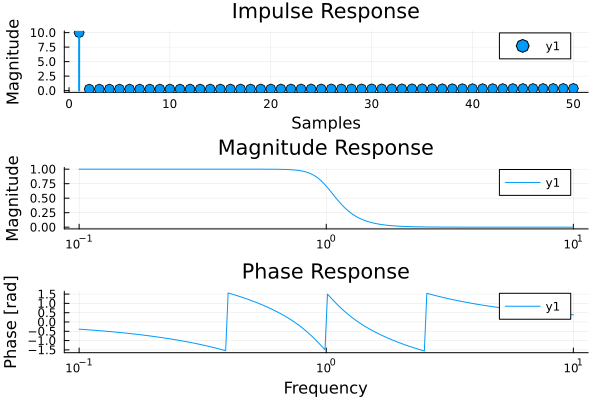

In [2]:
x = vcat([1], zeros(Float64, (49,1)))

bwf = Butterworth(6)
h, w = freqresp(bwf)

filt_butter = filt(h,w,x)
mag = abs.(h)
phase = atan.(imag.(h)./real.(h))

p0 = plot(abs.(filt_butter), title="Impulse Response", lines=:stem, marker=:o, markersize=5, linewidth=2)
yaxis!("Magnitude")
xaxis!("Samples")
p1 = plot(w, mag, title="Magnitude Response", xaxis=:log)
yaxis!("Magnitude")
p2 = plot(w, phase, title="Phase Response", xaxis=:log)
yaxis!("Phase [rad]")
xaxis!("Frequency")

plot(p0, p1, p2, layout=(3,1))

2. through 4. - We repeat the same steps as #1 while keeping the ripple parameters in mind.

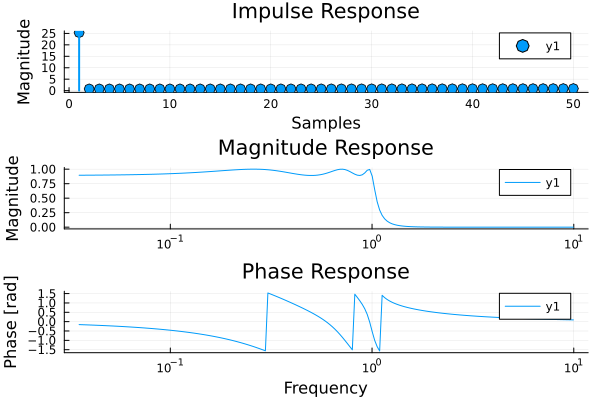

In [3]:
c1f = Chebyshev1(6, 1)
h, w = freqresp(c1f)

filt_chev1 = filt(h,w,x)
mag = abs.(h)
phase = atan.(imag.(h)./real.(h))

p0 = plot(abs.(filt_chev1), title="Impulse Response", lines=:stem, marker=:o, markersize=5, linewidth=2)
yaxis!("Magnitude")
xaxis!("Samples")
p1 = plot(w, mag, title="Magnitude Response", xaxis=:log)
yaxis!("Magnitude")
p2 = plot(w, phase, title="Phase Response", xaxis=:log)
yaxis!("Phase [rad]")
xaxis!("Frequency")

plot(p0, p1, p2, layout=(3,1))

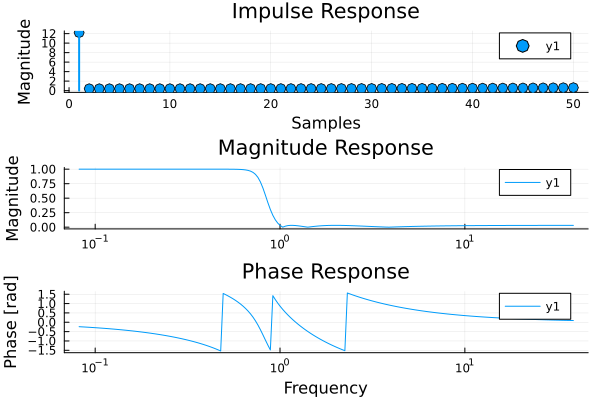

In [4]:
c2f = Chebyshev2(6, 30)
h, w = freqresp(c2f)

filt_chev2 = filt(h,w,x)
mag = abs.(h)
phase = atan.(imag.(h)./real.(h))

p0 = plot(abs.(filt_chev2), title="Impulse Response", lines=:stem, marker=:o, markersize=5, linewidth=2)
yaxis!("Magnitude")
xaxis!("Samples")
p1 = plot(w, mag, title="Magnitude Response", xaxis=:log)
yaxis!("Magnitude")
p2 = plot(w, phase, title="Phase Response", xaxis=:log)
yaxis!("Phase [rad]")
xaxis!("Frequency")

plot(p0, p1, p2, layout=(3,1))

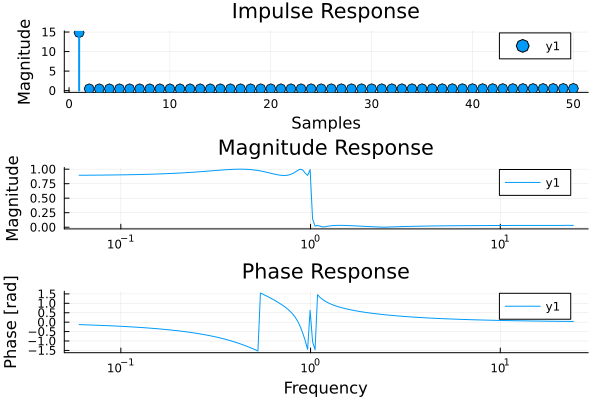

In [5]:
ef = Elliptic(6,1,30)
h, w = freqresp(ef)

filt_ef = filt(h,w,x)
mag = abs.(h)
phase = atan.(imag.(h)./real.(h))

p0 = plot(abs.(filt_ef), title="Impulse Response", lines=:stem, marker=:o, markersize=5, linewidth=2)
yaxis!("Magnitude")
xaxis!("Samples")
p1 = plot(w, mag, title="Magnitude Response", xaxis=:log)
yaxis!("Magnitude")
p2 = plot(w, phase, title="Phase Response", xaxis=:log)
yaxis!("Phase [rad]")
xaxis!("Frequency")

plot(p0, p1, p2, layout=(3,1))

5. Using the <code>WAV</code> package, we can load the .wav file into the worksheet and separate the channels and sample frequency

In [6]:
y, Fs = wavread("doorbell.wav")


([0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], 48000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x02, 0x00, 0x80, 0xbb, 0x00, 0x00, 0x00, 0xee, 0x02, 0x00, 0x04, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x53, 0x46, 0x54, 0x08, 0x00, 0x00, 0x00, 0x46, 0x69, 0x73, 0x73, 0x69, 0x6f, 0x6e, 0x00])])

The .wav is quite long, so we truncate 1/32<sup>nd</sup> of the total sound to analyze

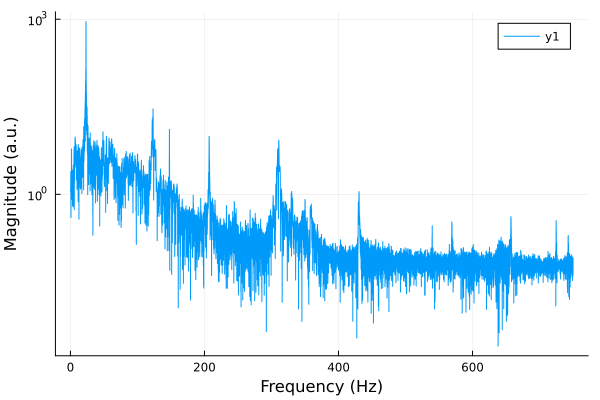

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [70]:
N = floor(Int,length(y[:,1])/32)
Y = fftshift(abs.(fft(y[1:N,1])))[floor(Int, N/2):N]
nPts = floor(Int, (N+1)/2)
ν = (1:1:nPts+1).*(Fs/32/N)

plot(ν, Y, yaxis=:log)
xaxis!("Frequency (Hz)")
yaxis!("Magnitude (a.u.)")

There are 5 frequencies contributing to the sound of the bell.